# Lectures 7: Class demo IMDB Reviews

## Imports

In [1]:
import os
import sys

sys.path.append(os.path.join("code"))
from utils import *
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
%matplotlib inline
URL_DATA_DIR = "https://github.com/firasm/bits/raw/refs/heads/master/imdb_small.csv"
pd.set_option("display.max_colwidth", 200)

## Demo: Model interpretation of linear classifiers

- One of the primary advantage of linear classifiers is their ability to interpret models. 
- For example, with the sign and magnitude of learned coefficients we could answer questions such as which features are driving the prediction to which direction. 

- We'll demonstrate this by training `LogisticRegression` on the famous [IMDB movie review](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) dataset. The dataset is a bit large for demonstration purposes. So I am going to put a big portion of it in the test split to speed things up. 

In [9]:
imdb_df = pd.read_csv(URL_DATA_DIR, encoding="ISO-8859-1")
imdb_df.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",positive


Let's clean up the data a bit. 

In [10]:
import re

def replace_tags(doc):
    doc = doc.replace("<br />", " ")
    doc = re.sub(r"https://\S*", "", doc)
    return doc

In [11]:
imdb_df["review_pp"] = imdb_df["review"].apply(replace_tags)

### Activity: Discuss the following questions in your group

- Are we breaking the Golden rule here?
- Why or How?

<br><br><br><br>

### Let's split the data and create bag of words representation.

This is a very large dataset (and even now we're only working with a fifth of its actual size), so we're going to put a lot of it to the test set so the calculations don't take forever!

In [13]:
train_df, test_df = train_test_split(imdb_df, test_size=0.7, random_state=123)
X_train, y_train = train_df["review_pp"], train_df["sentiment"]
X_test, y_test = test_df["review_pp"], test_df["sentiment"]
train_df.shape

(2999, 3)

In [14]:
vec = CountVectorizer(stop_words="english")
bow = vec.fit_transform(X_train)
bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 262416 stored elements and shape (2999, 30438)>

### Examining the vocabulary

- The vocabulary (mapping from feature indices to actual words) can be obtained using `get_feature_names_out()` on the `CountVectorizer` object. 

In [15]:
vocab = vec.get_feature_names_out()

In [16]:
vocab[0:10]  # first few words

array(['00', '000', '00001', '007', '00am', '01', '0126', '01pm', '02',
       '04'], dtype=object)

In [17]:
vocab[2000:2010]  # some middle words

array(['au', 'aubrey', 'auction', 'audacious', 'audacity', 'audible',
       'audience', 'audiences', 'audio', 'audit'], dtype=object)

In [18]:
vocab[::500]  # words with a step of 500

array(['00', 'academic', 'alberson', 'apartments', 'au', 'bats', 'bladk',
       'branch', 'byrnes', 'cavepeople', 'chupacabras', 'comic',
       'contribute', 'crossover', 'deceptions', 'devgun', 'disused',
       'dungeon', 'employment', 'excessive', 'faust', 'fluent', 'fusing',
       'glitches', 'guano', 'headless', 'honorary', 'impassioned',
       'instructor', 'jefferson', 'killshot', 'learn', 'looker',
       'manhole', 'mechanics', 'mistake', 'musgrove', 'nipped',
       'onlookers', 'palpably', 'personally', 'polically', 'procedure',
       'quips', 'redrum', 'restores', 'rory', 'scare', 'seriousness',
       'silk', 'snout', 'sprinkled', 'stricken', 'swami', 'terence',
       'topped', 'turgid', 'unmarysuish', 'vexes', 'wealth', 'woodward'],
      dtype=object)

In [19]:
y_train.value_counts()

sentiment
positive    1513
negative    1486
Name: count, dtype: int64

### Model building on the dataset 

First let's try `DummyClassifier` on the dataset. 

In [20]:
dummy = DummyClassifier()
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.001000,0.001999,0.505000,0.504377
1,0.000998,0.001003,0.505000,0.504377
2,0.001000,0.001001,0.505000,0.504377
3,0.002001,0.000999,0.503333,0.504794
4,0.001002,0.000999,0.504174,0.504583


We have a balanced dataset. So the `DummyClassifier` score is around 0.5. 

Now let's try logistic regression. 

In [21]:
pipe_lr = make_pipeline(
    CountVectorizer(stop_words="english"),
    LogisticRegression(max_iter=1000),
)
scores = cross_validate(pipe_lr, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.461464,0.068000,0.850000,1.0
1,0.460001,0.077999,0.840000,1.0
2,0.487011,0.077001,0.820000,1.0
3,0.484000,0.096999,0.858333,1.0
4,0.413023,0.074001,0.828047,1.0


Seems like we are overfitting. Let's optimize the hyperparameter `C` of LR and `max_features` of `CountVectorizer`. 

In [22]:
scores_dict = {
    "C": 10.0 ** np.arange(-3, 3, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for C in scores_dict["C"]:
    pipe_lr = make_pipeline(CountVectorizer(max_features=10_000, stop_words="english"),
                        LogisticRegression(max_iter=1000, C=C)
                       )
    scores = cross_validate(pipe_lr, X_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df

,C,mean_train_scores,mean_cv_scores
0,0.001,0.821273,0.774924
1,0.010,0.930226,0.833939
2,0.100,0.992664,0.843608
3,1.000,1.000000,0.839943
4,10.000,1.000000,0.836610
5,100.000,1.000000,0.833609


In [23]:
optimized_C = results_df["C"][results_df["mean_cv_scores"].idxmax()]
print(
    "The maximum validation score is %0.3f at C = %0.2f "
    % (
        np.max(results_df["mean_cv_scores"]),
        optimized_C,
    ))

The maximum validation score is 0.844 at C = 0.10 


In [25]:
pipe_lr = make_pipeline(CountVectorizer(max_features=10000, stop_words="english"),
                        LogisticRegression(max_iter=1000, C = 0.10)
                       )
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=10000, stop_words='english')),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=1000))])

### Examining learned coefficients 

- The learned coefficients are exposed by the `coef_` attribute of [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) object. 

In [26]:
# Get feature names
feature_names = pipe_lr.named_steps['countvectorizer'].get_feature_names_out().tolist()

# Get coefficients 
coeffs = pipe_lr.named_steps["logisticregression"].coef_.flatten()

In [27]:
word_coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
word_coeff_df

,Coefficient
00,0.000523
000,0.004950
007,0.074111
01,0.017173
10,-0.047450
...,...
zombie,0.036335
zombies,-0.009433
zone,0.093419
zoom,-0.011210


- Let's sort the coefficients in descending order. 
- Interpretation
    - if $w_j > 0$ then increasing $x_{ij}$ moves us toward predicting $+1$. 
    - if $w_j < 0$ then increasing $x_{ij}$ moves us toward predicting $-1$. 


In [28]:
word_coeff_df.sort_values(by="Coefficient", ascending=False)

,Coefficient
excellent,0.765682
perfect,0.533964
wonderful,0.527853
enjoyed,0.523159
loved,0.506878
...,...
instead,-0.624578
awful,-0.670822
waste,-0.689985
poor,-0.702775


- The coefficients make sense!

Let's visualize the top 20 features.

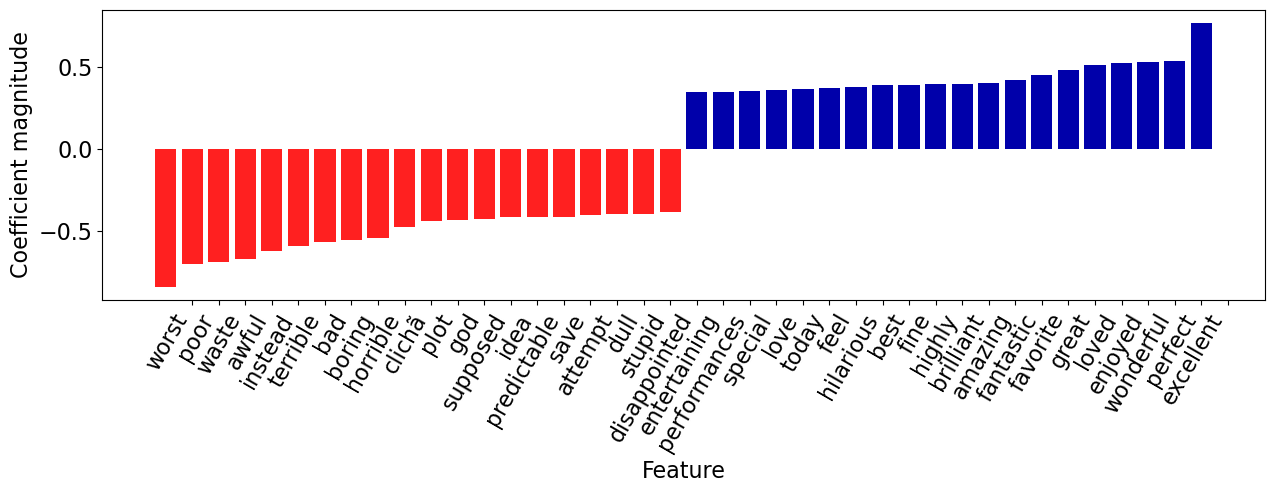

In [30]:
mglearn.tools.visualize_coefficients(coeffs, feature_names, n_top_features=20)

Let's explore prediction of the following new review. 

In [31]:
fake_reviews = ["It got a bit boring at times but the direction was excellent and the acting was flawless. Overall I enjoyed the movie and I highly recommend it!",
 "The plot was shallower than a kiddie pool in a drought, but hey, at least we now know emojis should stick to texting and avoid the big screen."
]

Let's get prediction probability scores of the fake review. 

In [32]:
pipe_lr.predict(fake_reviews)

array(['positive', 'negative'], dtype=object)

In [33]:
# Get prediction probabilities for fake reviews 
pipe_lr.predict_proba(fake_reviews)

array([[0.12358584, 0.87641416],
       [0.63773958, 0.36226042]])

In [37]:
pipe_lr.classes_

array(['negative', 'positive'], dtype=object)

We can find which of the vocabulary words are present in this review:

In [38]:
def plot_coeff_example(model, review, coeffs, feature_names, n_top_feats=6):
    print(review)
    feat_vec = model.named_steps["countvectorizer"].transform([review])
    words_in_ex = feat_vec.toarray().ravel().astype(bool)

    ex_df = pd.DataFrame(
        data=coeffs[words_in_ex],
        index=np.array(feature_names)[words_in_ex],
        columns=["Coefficient"],
    )
    mglearn.tools.visualize_coefficients(
    coeffs[words_in_ex], np.array(feature_names)[words_in_ex], n_top_features=n_top_feats
    )
    return ex_df.sort_values(by=["Coefficient"], ascending=False)

It got a bit boring at times but the direction was excellent and the acting was flawless. Overall I enjoyed the movie and I highly recommend it!


,Coefficient
excellent,0.765682
enjoyed,0.523159
highly,0.394696
bit,0.321689
recommend,0.242084
times,0.153180
flawless,0.098013
overall,0.016189
got,0.008625
movie,-0.007893


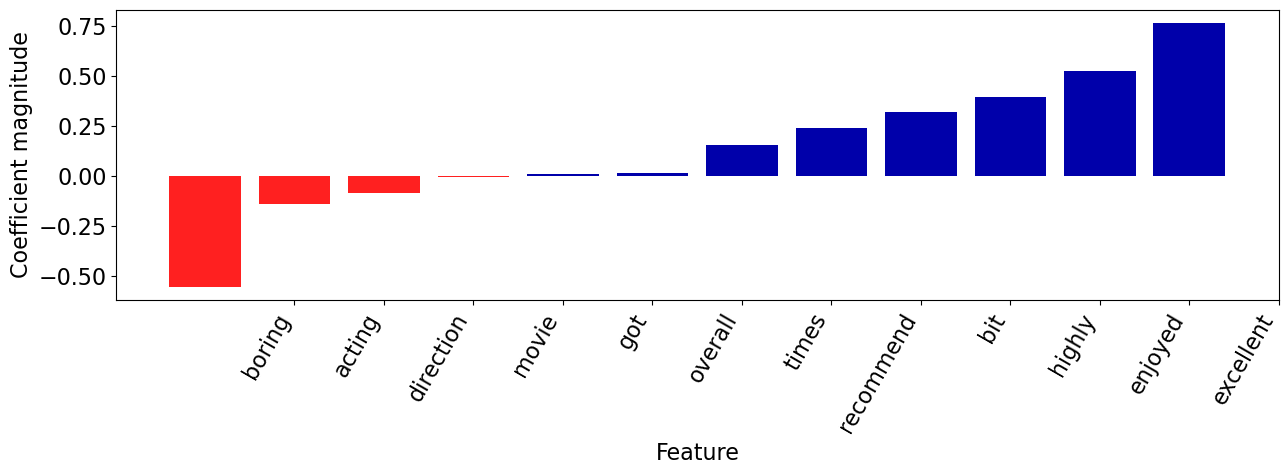

In [39]:
plot_coeff_example(pipe_lr, fake_reviews[0], coeffs, feature_names)

The plot was shallower than a kiddie pool in a drought, but hey, at least we now know emojis should stick to texting and avoid the big screen.


,Coefficient
know,0.100988
pool,0.046735
hey,0.026768
kiddie,-0.004505
screen,-0.018955
big,-0.092483
stick,-0.102944
avoid,-0.303257
plot,-0.442446


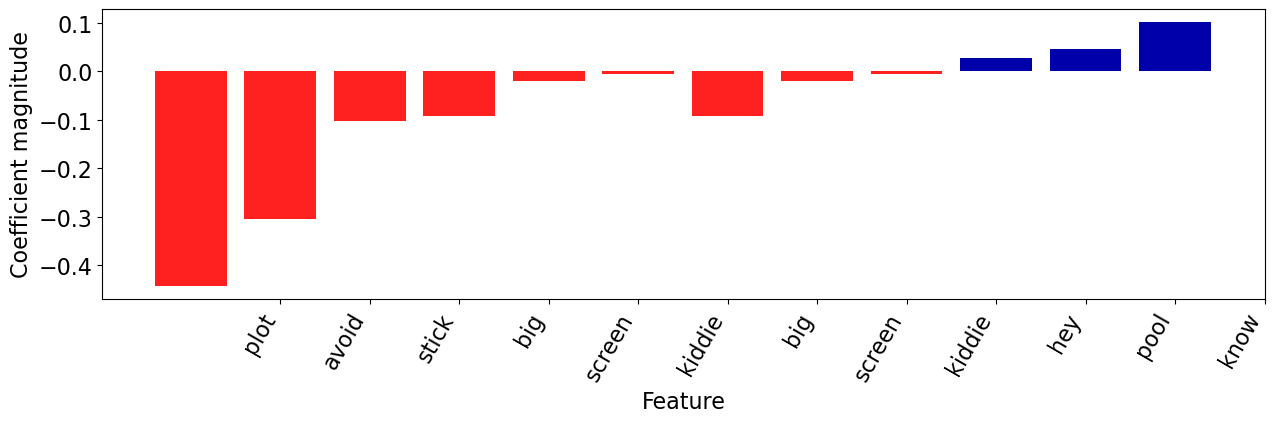

In [40]:
plot_coeff_example(pipe_lr, fake_reviews[1], coeffs, feature_names)

<br><br><br><br>

### Most positive review 

- Remember that you can look at the probabilities (confidence) of the classifier's prediction using the `model.predict_proba` method.
- Can we find the reviews where our classifier is most certain or least certain?

In [41]:
# only get probabilities associated with pos class
pos_probs = pipe_lr.predict_proba(X_train)[
    :, 1
]  # only get probabilities associated with pos class
pos_probs

array([0.89358994, 0.90478651, 0.00191901, ..., 0.01428111, 0.79238893,
       0.33434653], shape=(2999,))

What's the index of the example where the classifier is most certain (highest `predict_proba` score for positive)?

In [45]:
most_positive_id = np.argmax(pos_probs)
most_positive_id

np.int64(1117)

In [46]:
print("True target: %s\n" % (y_train.iloc[most_positive_id]))
print("Predicted target: %s\n" % (pipe_lr.predict(X_train.iloc[[most_positive_id]])[0]))
print("Prediction probability: %0.4f" % (pos_probs[most_positive_id]))

True target: positive

Predicted target: positive

Prediction probability: 1.0000


Let's examine the features associated with the review. 

Horror-genius Dario Argento is one of my personal favorite directors, and his films "Suspiria", "Phenomena" and "Profondo Rosso" range high on my personal all-time favorite list. "Opera" of 1987 is yet another tantalizing and brilliant film that no Horror lover can afford to miss, and that will keep you on the edge of your chair from the beginning to the end. This stunning and ultra-violent Giallo could well be described as the master's nastiest film, which is quite something considering that Argento's films are not exactly known for the tameness of their violence. The violence is extreme and very stylized in a brilliant way that makes Opera a film censor's nightmare.  - Warning! SPOILERS ahead! -   Just when Betty (Christina Marsillach), a young opera singer, is becoming successful, a murderous and incredibly sadistic psychopath starts stalking her... The murders are truly brutal, and of particularly sadistic nature. The killer attaches needles to the tied up Betty's eyelids, so she h

,Coefficient
excellent,0.765682
great,0.477544
favorite,0.447169
brilliant,0.396800
highly,0.394696
...,...
girlfriend,-0.143693
just,-0.145718
director,-0.245329
lead,-0.247726


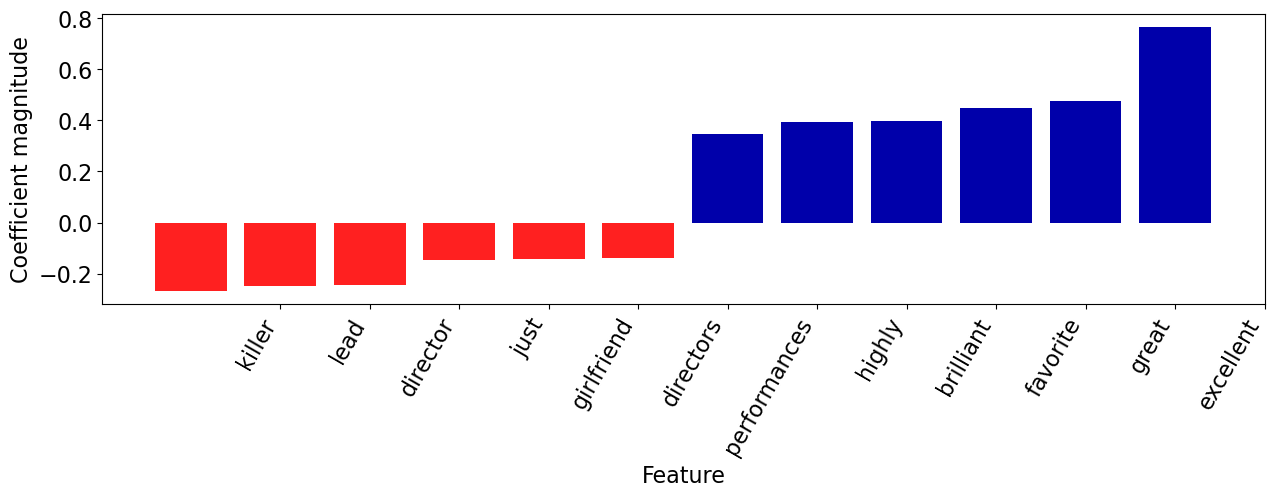

In [47]:
plot_coeff_example(pipe_lr, X_train.iloc[most_positive_id], coeffs, feature_names)

The review has both positive and negative words but the words with **positive** coefficients win in this case! 

### Most negative review 

In [48]:
neg_probs = pipe_lr.predict_proba(X_train)[
    :, 0
]  # only get probabilities associated with neg class
neg_probs

array([0.10641006, 0.09521349, 0.99808099, ..., 0.98571889, 0.20761107,
       0.66565347], shape=(2999,))

In [49]:
most_negative_id = np.argmax(neg_probs)

In [50]:
print("Review: %s\n" % (X_train.iloc[[most_negative_id]]))
print("True target: %s\n" % (y_train.iloc[most_negative_id]))
print("Predicted target: %s\n" % (pipe_lr.predict(X_train.iloc[[most_negative_id]])[0]))
print("Prediction probability: %0.4f" % (neg_probs[most_negative_id]))

Review: 1735    Komodo vs. Cobra starts as 'One Planet' environmentalist Jerry Ryan (Ryan McTavish) & his girlfriend Carrie (Renee Talbert) hire Captain Michael Stoddard (executive producer Michael ParÃ©) to take...
Name: review_pp, dtype: object

True target: negative

Predicted target: negative

Prediction probability: 1.0000


Komodo vs. Cobra starts as 'One Planet' environmentalist Jerry Ryan (Ryan McTavish) & his girlfriend Carrie (Renee Talbert) hire Captain Michael Stoddard (executive producer Michael ParÃ©) to take them to an island in the South Pacific, at first Stoddard is reluctant since the island is a top secret military research base but soon changes his mind when a load of cash is offered. Along with TV news reporter Sandra Crescent (Jeri Manthey) they set sail for the island & once ashore find out that the military have been funding illegal DNA genetic experiments which have resulted in huge Komodo Dragon's & King Cobra's that have eaten almost every other living thing there & Stoddard & co are next on the menu...  Co-written & directed by the ever awful Jim Wynorski under his Jay Andrews pseudonym this is just plain awful, this is just plain hard to sit through & is even worse than the usual rubbish 'Creature Features' the Sci-Fi Channel have the nerve to air if that's possible. The script is t

,Coefficient
bit,0.321689
beautiful,0.311584
fun,0.307410
ryan,0.197469
monsters,0.184477
...,...
boring,-0.554600
terrible,-0.593401
awful,-0.670822
poor,-0.702775


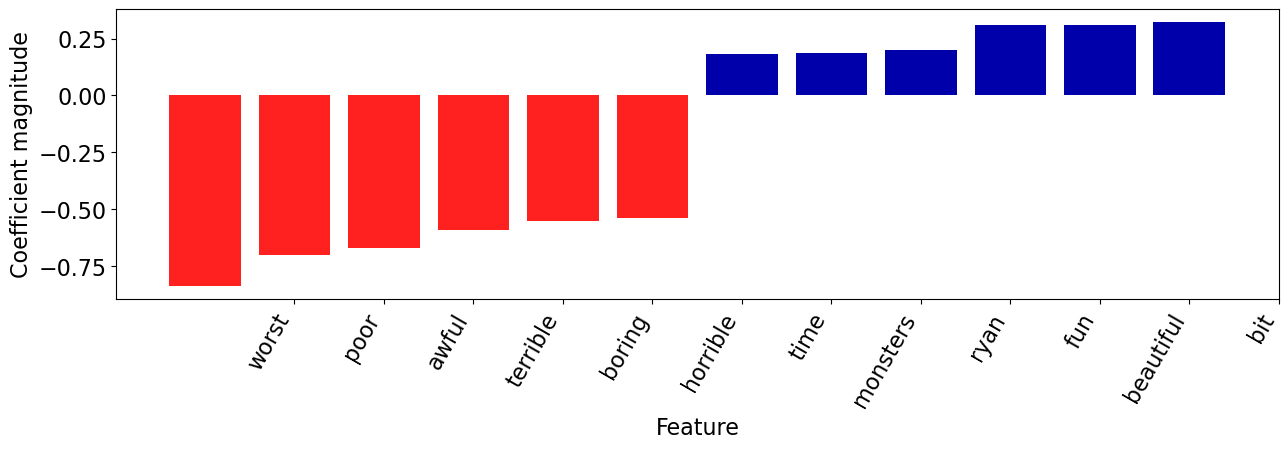

In [51]:
plot_coeff_example(pipe_lr, X_train.iloc[most_negative_id], coeffs, feature_names)

The review has both positive and negative words but the words with negative coefficients win in this case! 

## Activity: Discuss the following questions in your group

- Is it possible to identify most important features using $k$-NNs? What about decision trees?  

<br><br><br><br>